<a href="https://colab.research.google.com/github/emyesme/CalcificationDetection/blob/Zarin/proi_file_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# just once to install opencv
!pip install opencv-python

In [28]:
# just once to install matplotlib
!pip install matplotlib

In [2]:
# just once to install numpy
!pip install numpy

In [ ]:
# just once to install google.colab
#!pip install google-colab

In [ ]:
#!pip install PyWavelets

In [ ]:
#!pip install image_dehazer

In [3]:
!pip install -U scikit-image

     |████████████████████████████████| 13.5 MB 5.1 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [27]:
#!pip install fastprogress
from fastprogress import master_bar, progress_bar

In [4]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import os 

#first put a shortcut in your drive to the image processing folder

DATA_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Image Processing and Analysis 2022',
                        'projects',
                        'Calcification Detection',
                        'dataset')


print(os.listdir(DATA_DIR))

['normals.txt', 'images', 'groundtruths', 'masks']


In [ ]:
# os.listdir(DATA_DIR + "/groundtruths")

In [7]:
# import opencv
import cv2
# import numpy
import numpy as np
import pandas as pd

In [112]:
roi_mc_header = pd.DataFrame(columns=["roi_width = 12;", "roi_height = 12;", "pyramid_scale_factor = 1"," "," "])

roi_mc_header.to_csv( os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Microcalcification Detection',
                        'Code',
                        'roi_mc_12.csv'), index=False, mode='a')

roi_bg_header = pd.DataFrame(columns=["roi_width = 12;", "roi_height = 12;", "pyramid_scale_factor = 1"," "," "])

roi_bg_header.to_csv( os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Microcalcification Detection',
                        'Code',
                        'roi_bg_12.csv'), index=False, mode='a')

In [106]:
roi_mc=[]
roi_bg=[]

roi_mc

[]

In [51]:
def roiExtract(matrix,gt,image,roi_mc,roi_bg):
  
  roi_height=12
  roi_width=12
  matrix_height=matrix.shape[0]
  matrix_width=matrix.shape[1]
  img_patch=[]
  gt_patch=[]

  for j in range(0,matrix_height,12):
    for i in range(0,matrix_width,12):
      # [row, column] = [height, width] = [0, 1]
      img_patch=matrix[j:j+roi_height, i:i+roi_width]
      gt_patch=gt[j:j+roi_height, i:i+roi_width]

      #roi_row=[]      

      if ((img_patch.shape[0] == 12) and (img_patch.shape[1] == 12)) :

        #roi_row=[image, 0, i, j, -1]

        if np.amax(gt_patch)>0:
          roi_mc.append([image, 0, i, j, -1])
          # roi_mc.loc[len(roi_mc)] = [image, 0, i, j, -1]
        
        # else:
          # roi_bg.append([image, 0, i, j, -1])
          # roi_bg=roi_bg.append([image, 0, i, j, -1], ignore_index=True)

  return roi_mc,roi_bg

In [ ]:
# preprocessing
# here explain what you code
def preprocessingWavelet(matrix, mask):
  # wavelet high pass, low pass or low pass, high pass, high pass high pass.
  import pywt  

  # enhancement
  # Comparing the Performance of Image Enhancement Methods
  # to Detect Microcalcification Clusters in Digital Mammography, Moradmand, Hajar, 2012

  # Five-level   discrete   wavelet decomposition  was  employed  by  using  Asymmetric Daubechies  of  order  8; 

  # normal wavelet from stackoverflow
  # convert to grayscale
  grayscale = cv2.cvtColor(matrix, cv2.COLOR_BGR2GRAY)

  # convert to float
  arrayFloat = np.float32(grayscale)
  arrayFloat /= 255
  
  # compute coefficients
  coeffs = pywt.wavedec2(arrayFloat,'haar',level=10)

  #process coefficients
  coeffs_H = list(coeffs)
  coeffs_H[0] *= 0

  # reconstruction
  arrayFloat_H = pywt.waverec2(coeffs_H, 'haar')
  arrayFloat_H *= 255
  arrayFloat_H = np.uint8(arrayFloat_H)

  preprocessed = arrayFloat_H
  return preprocessed

In [ ]:
# preprocessing
# here explain what you code
def preprocessingDeHazingPy(matrix, mask):
  # https://link.springer.com/chapter/10.1007/978-3-319-68548-9_27
  # the professor say we can take the grays in the mammogram as haze. so use dehazing

  # still no the hazing method that he use this is just one found in a python library
  # https://github.com/Utkarsh-Deshmukh/Single-Image-Dehazing-Python
  # dehazing

  import image_dehazer	# Load the library

  hazeCorrectedImg = image_dehazer.remove_haze(matrix)		# Remove Haze

  preprocessed = hazeCorrectedImg
  return preprocessed

In [ ]:
# dehaze single image using dark channel prior and guided filter
# taken from a repository 
# https://github.com/He-Zhang/image_dehaze
# dehazing method proposed by the professor 
# simple imaging dehazing using dark channel prior (and guided filter, readme.md of the repo say that)
import math

# change this methods to do just grayscale will be nice

def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

def TransmissionEstimate(im,A,sz):
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]
    return res

def deHazingDarkChannelPriorPy(matrix, mask):

    I = matrix.astype(np.float64)/255
 
    dark = DarkChannel(I,15)
    A = AtmLight(I,dark)
    te = TransmissionEstimate(I,A,15)
    t = TransmissionRefine(matrix,te)
    J = Recover(I,t,A,0.1)
    preprocessed = J
    return preprocessed

# image = cv2.imread(DATA_DIR+"/images/53582422_3f0db31711fc9795_MG_R_ML_ANON.tif")
# dark, t, matrix, J = deHazingDarkChannelPriorPy(image, image)


In [57]:
# candidateExtraction
# here explain what you code
# Hessian-matrix-based analysis or difference of gaussians (DoH) blob detection from skimage
# https://scikit-image.org/docs/stable/api/skimage.feature.html?highlight=local%20binary%20pattern#skimage.feature.blob_doh
def candidateExtraction(matrix, mask):

  from skimage import feature

  # returns x,y,sigma of the blob
  blobs = feature.blob_doh(matrix,
                           min_sigma=1,
                           max_sigma=30,
                           num_sigma=10,
                           # The absolute lower bound for scale space maxima.
                           # Local maxima smaller than threshold are ignored.
                           # Reduce this to detect blobs with lower intensities.
                           # If threshold_rel is also specified, whichever threshold is larger will be used.
                           # If None, threshold_rel is used instead.
                           threshold=0.005,
                           # lower more sensible, more false positives bad also tinier calcifications detected
                           overlap=0.5,
                           log_scale=False,
                           threshold_rel=None
                           )
  # taken from the documentation
  # ...The downside is that this method can’t be used for detecting blobs of radius less than 3px
  # due to the box filters used in the approximation of Hessian Determinant.
  result = blobs
  return result

In [ ]:
# # featuresExtraction
# # here explain what you code
# def featuresExtraction(matrix, candidates, features, mask):
  
#   # distances
#   # taking into account the microcalcifications can be less that 5 pixels
#   # distances should vary with that
#   distances = [1, 3, 5, 7]# probably we need bigger
#   # angles
#   #         0     45      90       135
#   angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]


#   # patches
#   patches = []
#   for candidate in candidates:
#     # candidate points are save as np.float64
#     # to use them as coordinates they have to be integers
#     candidate = candidate.astype(np.int64)
#     # candidates are x,y and sigma
#     patchCandidate = matrix[candidate[0]:candidate[0] + candidate[2],
#                             candidate[1]:candidate[1] + candidate[2]]

#     # reduce even more the shades of gray T-T
#     # graycomatrix, glcm, receive unsigned integer type
#     # but if it is bigger that np.uint8 you have to change the levels argument
#     # of graycomatrix for the shades of gray, if it is np.uint16, levels shoud be
#     # aprox 65 535. that break the colab :c 
#     patchCandidate = patchCandidate.astype(np.uint8)
#     # add to the list
#     patches.append(patchCandidate)
  
#   # https://www.youtube.com/watch?v=5x-CIHRmMNY
#   # https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html
#   # https://ijcrr.com/uploads/3454_pdf.pdf

#   from skimage import feature
#   import itertools
#   # combination of distances and angles as couples of values
#   distancesAngles = list(itertools.product(distances, angles))

#   for patch in patches:
#     for distanceAngle in distancesAngles:
#       distance = distanceAngle[0]
#       angle = distanceAngle[1]
#       # get the degree to use it as name for the column
#       name = str(angle*(180.0/np.pi))
#       # input image, distance in pixels, angles
#       glcm = feature.graycomatrix(patch, [ distance ], [ angle ])
#       # Output: the gray-level co-occurrence histogram. The value P[i,j,d,theta]
#       # is the number of times that gray-level j occurs at a distance d
#       # and at an angle theta from gray-level i.
#       # If normed is False, the output is of type uint32, otherwise it is float64.
#       # The dimensions are: levels x levels x number of distances x number of angles.

#       # properties: {‘contrast’, ‘dissimilarity’, ‘homogeneity’, ‘energy’, ‘correlation’, ‘ASM’}
#       features['contrast'+ str(distance) + name] = feature.graycoprops(glcm, 'contrast')[0]
#       features['dissimilarity' + str(distance) + name] = feature.graycoprops(glcm, 'dissimilarity')[0]
#       features['homogeneity' + str(distance) + name] = feature.graycoprops(glcm, 'homogeneity')[0]
#       features['energy' + str(distance) + name] = feature.graycoprops(glcm, 'energy')[0]
#       features['correlation' + str(distance) + name] = feature.graycoprops(glcm, 'correlation')[0]
#       features['ASM' + str(distance) + name] = feature.graycoprops(glcm, 'ASM')[0]

#       # print('contrast ', features['contrast'+ str(distance) + name])
#       # print('dissimilarity ', features['dissimilarity' + str(distance) + name])
#       # print('homogeneity ', features['homogeneity' + str(distance) + name])
#       # print('energy ', features['energy' + str(distance) + name])
#       # print('correlation ', features['correlation' + str(distance) + name])
#       # print('asm ', features['ASM' + str(distance) + name])
#       if ((distance  == 5) and (angle == 3*np.pi/4)):
      
#         print('creation')
#         print(feature.graycoprops(glcm, 'contrast'))

#       # https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.graycoprops
#       # Compute a feature of a gray level co-occurrence matrix to serve as a compact summary of the matrix.
#       # The properties are computed as follows:
#       # contrast
#       # dissimilarity
#       # homogeneity
#       # ASM
#       # energy

#   print('function')
#   print('value ', features['contrast5135'])

#   return features



In [ ]:
# featuresExtraction
# Local Binary Pattern + GLCM statistical feature set for feature extraction
# Sadad T, Munir A, Saba T, Hussain A, Fuzzy C-Means and Region Growing based Classification of Tumor from Mammograms using Hybrid Texture Features, Journal of Computational Science (2018),
# https://doi.org/10.1016/j.jocs.2018.09.015

def featuresExtractionLBP(matrix, candidates, featuresLBP, mask):
  
  # distances
  # taking into account the microcalcifications can be less that 5 pixels
  # distances should vary with that
  distances = [1, 3, 5, 7]# probably we need bigger
  # angles
  #         0     45      90       135
  angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]


  # patches
  patches = []
  for candidate in candidates:
    # candidate points are save as np.float64
    # to use them as coordinates they have to be integers
    candidate = candidate.astype(np.int64)
    # candidates are x,y and sigma
    patchCandidate = matrix[candidate[0]:candidate[0] + candidate[2],
                            candidate[1]:candidate[1] + candidate[2]]

    # reduce even more the shades of gray T-T
    # graycomatrix, glcm, receive unsigned integer type
    # but if it is bigger that np.uint8 you have to change the levels argument
    # of graycomatrix for the shades of gray, if it is np.uint16, levels shoud be
    # aprox 65 535. that break the colab :c 
    patchCandidate = patchCandidate.astype(np.uint8)
    # add to the list
    patches.append(patchCandidate)
  
  # https://www.youtube.com/watch?v=5x-CIHRmMNY
  # https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html
  # https://ijcrr.com/uploads/3454_pdf.pdf

  from skimage import feature
  import itertools
  from skimage.feature import local_binary_pattern

  # combination of distances and angles as couples of values
  distancesAngles = list(itertools.product(distances, angles))

  for patch in patches:
    for distanceAngle in distancesAngles:

      # LBP
      #https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html
      #https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.local_binary_pattern

      radius= 1
      points= 8 * radius

      #patchLBP = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
      patchLBP = local_binary_pattern(patchLBP, points, radius, method='default')      

      # GLCM from LBP
      

      distance = distanceAngle[0]
      angle = distanceAngle[1]
      # get the degree to use it as name for the column
      name = str(angle*(180.0/np.pi))
      # input image, distance in pixels, angles
      glcm = feature.graycomatrix(patchLBP, [ distance ], [ angle ])
      # Output: the gray-level co-occurrence histogram. The value P[i,j,d,theta]
      # is the number of times that gray-level j occurs at a distance d
      # and at an angle theta from gray-level i.
      # If normed is False, the output is of type uint32, otherwise it is float64.
      # The dimensions are: levels x levels x number of distances x number of angles.

      # properties: {‘contrast’, ‘dissimilarity’, ‘homogeneity’, ‘energy’, ‘correlation’, ‘ASM’}
      featuresLBP['contrast'+ str(distance) + name] = feature.graycoprops(glcm, 'contrast')[0]
      featuresLBP['dissimilarity' + str(distance) + name] = feature.graycoprops(glcm, 'dissimilarity')[0]
      featuresLBP['homogeneity' + str(distance) + name] = feature.graycoprops(glcm, 'homogeneity')[0]
      featuresLBP['energy' + str(distance) + name] = feature.graycoprops(glcm, 'energy')[0]
      featuresLBP['correlation' + str(distance) + name] = feature.graycoprops(glcm, 'correlation')[0]
      featuresLBP['ASM' + str(distance) + name] = feature.graycoprops(glcm, 'ASM')[0]

      # print('contrast ', features['contrast'+ str(distance) + name])
      # print('dissimilarity ', features['dissimilarity' + str(distance) + name])
      # print('homogeneity ', features['homogeneity' + str(distance) + name])
      # print('energy ', features['energy' + str(distance) + name])
      # print('correlation ', features['correlation' + str(distance) + name])
      # print('asm ', features['ASM' + str(distance) + name])
      if ((distance  == 5) and (angle == 3*np.pi/4)):
      
        print('creation')
        print(feature.graycoprops(glcm, 'contrast'))

      # https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.graycoprops
      # Compute a feature of a gray level co-occurrence matrix to serve as a compact summary of the matrix.
      # The properties are computed as follows:
      # contrast
      # dissimilarity
      # homogeneity
      # ASM
      # energy

  print('function')
  print('value ', featuresLBP['contrast5135'])

  return featuresLBP



In [ ]:
# function to get connected components of the ground truth binary image
def componentsStatsGroundTruth(matrix):
    # getting the info of the components in the ground truth
    # second value is connectivity 4 or 8
    connectedComponentsGroundTruth = cv2.connectedComponentsWithStats(matrix, 8, cv2.CV_32S)

    # Get the results
    # The first cell is the number of labels
    num_labels = connectedComponentsGroundTruth[0]
    # The second cell is the label matrix
    labels = connectedComponentsGroundTruth[1]
    # The third cell is the stat matrix
    stats = connectedComponentsGroundTruth[2]
    # The fourth cell is the centroid matrix
    centroids = connectedComponentsGroundTruth[3]

    return num_labels, labels, stats, centroids

In [31]:
#import show special for google colab
from google.colab.patches import cv2_imshow
#import plt for display
import matplotlib.pyplot as plt

#go into de directory of the images

# this have 3 outputs root directory, the folders in the path and the files in the path.
# we ignore _ the two first because we are not interested in those
_, _, images = next(os.walk(os.path.join(DATA_DIR,'images')))
_, _, breastMasks = next(os.walk(os.path.join(DATA_DIR,'masks')))
_, _, groundTruths = next(os.walk(os.path.join(DATA_DIR, 'groundtruths')))

images.sort()
breastMasks.sort()
groundTruths.sort()

# read numbers of normal images
normals = []
with open(os.path.join(DATA_DIR,'normals.txt')) as f:
    for line in f:
        normals.append(line[:-1])



In [ ]:
# https://medium.com/@robertbracco1/configuring-google-colab-like-a-pro-d61c253f7573#a642
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [103]:
from matplotlib.patches import Circle

# function to draw the grid to display
def display_grid(figure, axis, img, imgGroundTruth, preprocessed, candidates, features):
  # draw in the axis the img
  axis[0][0].imshow(img)
  # switch off the axis of the plot
  axis[0][0].axis('off')
  # set a title for the plot
  axis[0][0].set_title('Image')

  axis[0][1].imshow(imgGroundTruth, cmap='gray')
  axis[0][1].axis('off')
  axis[0][1].set_title('Ground Truth')

  axis[0][2].imshow(imgMask)
  axis[0][2].axis('off')
  axis[0][2].set_title('Breast Mask')

  axis[1][0].imshow(preprocessed, cmap='gray')
  axis[1][0].axis('off')
  axis[1][0].set_title('Preprocessed')

  # draw candidates as circles
  axis[1][1].imshow(preprocessed, cmap='gray')
  axis[1][1].axis('off')
  axis[1][1].set_title('Candidates')

  # Now, loop through coord arrays, and create a circle at each x,y pair
  for x,y,sigma in candidates:
    blob = Circle((int(float(x)),int(float(y))), int(float(sigma)), color='blue', fill=False)
    axis[1][1].add_patch(blob)

  axis[1][2].imshow(imgGroundTruth, cmap='gray')
  axis[1][2].axis('off')
  axis[1][2].set_title('compare with ground truth and candidates')

  # Now, loop through coord arrays, and create a circle at each x,y pair
  for x,y,sigma in candidates:
    blob = Circle((int(float(x)),int(float(y))), int(float(sigma)), color='blue', fill=False)
    axis[1][2].add_patch(blob)
  
  return figure, axis


In [33]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



[['3327.0', '3326.0', '13.0'], ['3327.0', '3350.0', '20.0'], ['1996.0', '2817.0', '20.0'], ['3327.0', '3127.0', '13.0'], ['2073.0', '2917.0', '8.0'], ['1925.0', '1475.0', '8.0'], ['2190.0', '1685.0', '8.0'], ['2584.0', '1836.0', '13.0'], ['1974.0', '2400.0', '13.0'], ['2012.0', '1272.0', '13.0'], ['2686.0', '2094.0', '13.0'], ['1843.0', '1388.0', '13.0'], ['1961.0', '1104.0', '13.0'], ['2023.0', '1227.0', '13.0'], ['1975.0', '1789.0', '13.0'], ['2273.0', '1554.0', '8.0'], ['2138.0', '2962.0', '5.0'], ['2089.0', '1552.0', '13.0'], ['2522.0', '1610.0', '13.0'], ['2055.0', '1326.0', '8.0'], ['3323.0', '3301.0', '0.0'], ['2502.0', '1612.0', '8.0'], ['2279.0', '2822.0', '8.0'], ['2044.0', '2264.0', '5.0'], ['2142.0', '2998.0', '13.0'], ['2488.0', '2092.0', '8.0'], ['1982.0', '1071.0', '8.0'], ['2235.0', '1862.0', '8.0'], ['2438.0', '2034.0', '13.0'], ['2064.0', '1310.0', '8.0'], ['2357.0', '1948.0', '8.0'], ['2798.0', '1678.0', '8.0'], ['2368.0', '2787.0', '20.0'], ['2385.0', '1856.0', '13.

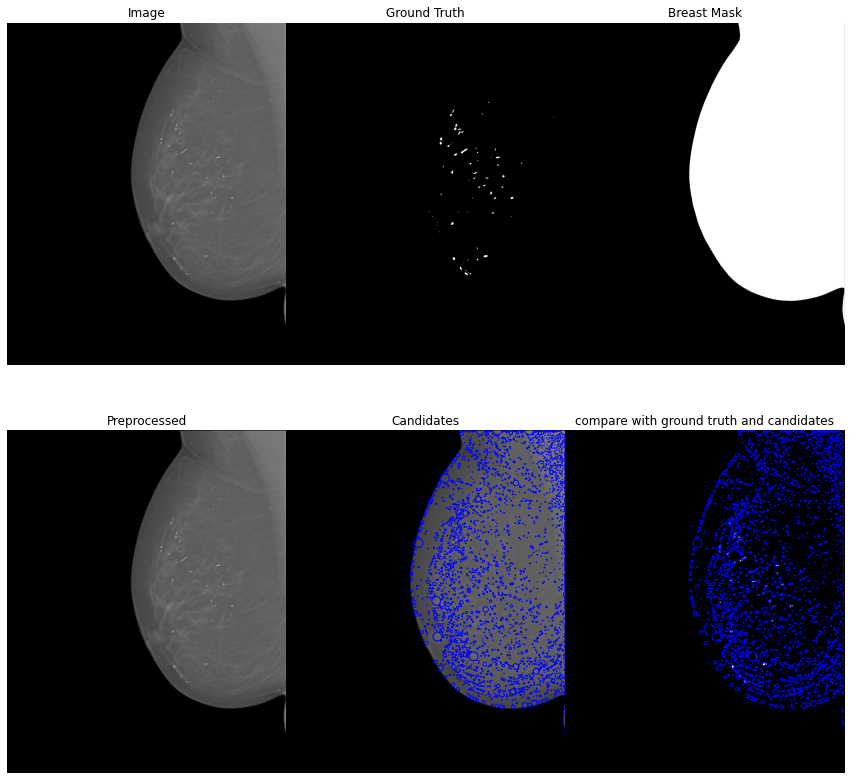

In [110]:
import copy
import pandas as pd

# to save the features generated with the glcm

# LBP+GLCM
# features = pd.DataFrame(dtype=np.float64)

# featuresLBP = pd.DataFrame(dtype=np.float64)

#go through the image files 
for image, breastMask, groundTruth in zip(progress_bar(images), breastMasks, groundTruths):
  # choose one
  # this are the last 4 of the number of the image name {numbers}_{}_{}_{}_{}_{}.tif
  # i suppose those are unique
  # if your code is working try other images!
  #print(breastMask)
  
  # restart variables for memory
  # to save the candidates
  blobs = {}
  # to sabe the ground truth connected components
  groundTruthsComponents = {}
  

  # 20588020, 7717, 5328, 3787, 5725, 3859, 6934, 50995872
  digits = '24055328'

  if ((digits in image) and (digits in breastMask) and ('mask' in breastMask)):
  #if ('mask' in breastMask):

    #upload images
    img = cv2.imread(os.path.join(DATA_DIR,'images',image))
    imgMask = cv2.imread(os.path.join(DATA_DIR, 'masks', breastMask))
    imgGroundTruth = cv2.imread(os.path.join(DATA_DIR, 'groundtruths', image), cv2.IMREAD_GRAYSCALE)

    # extracting roi

    roi_mc,roi_bg = roiExtract(img,imgGroundTruth,image,roi_mc,roi_bg)


    # processing necessary for evaluation

    # Get components of the ground truth
    '''
    num_labels, labels, stats, centroids = componentsStatsGroundTruth(imgGroundTruth)
    groundTruthsComponents[image] = {}
    groundTruthsComponents[image]['num_labels'] = num_labels
    groundTruthsComponents[image]['labels'] = labels
    groundTruthsComponents[image]['stats'] = stats
    groundTruthsComponents[image]['centroids'] = centroids
    '''
    # preprocessing #

    imgCopy = copy.deepcopy(img)
    preprocessed = copy.deepcopy(img)

    # preprocessed = preprocessingDeHazingPy(img, imgMask)
    # preprocessed = deHazingDarkChannelPriorPy(imgCopy, imgMask)
    # after preprocessingDeHazingPy + contrast streching to see
    # preprocessed = preprocessingDeHazingPy(imgCopy,imgMask)

      # still missing quantum noise supression
      # details in the phd defense file

      # still missing linear streching
        # keep going forever the code, computational cost

      # still missing CLAHE (adaptive histogram equalization) opencv library
        # CLAHE + dehazing bad results.
        # points less visible with CLAHE

        # dehazing + CLAHE 
        # black image

      # Observations from the results:

        # fiber intersections may also appear as bright spots (false positives)

      # THINGS WE NOTICE BETWEEN BOTH DEHAZING METHODS

        # Better suppression of fatty tissue (noise) and greater enhancement of brightness of desired feature (microcalcifications)

        # sometimes for the other dehazing method black patches become present in the fatty tissue
        # this did not happen in the dehazing with dark channel prior (and guided filter)

        # sharper

        # enhance the contrast

        # details were enhanced

    # candidate extraction #

    #copyPreprocessed = copy.deepcopy(preprocessed)

    # we have to change np.float64 to np.float32 for the grayscale conversion
    # leading to a reduction of gray values
    #copyPreprocessed = copyPreprocessed.astype(np.float32)
    #copyPreprocessed = cv2.cvtColor(copyPreprocessed, cv2.COLOR_BGR2GRAY)

    #candidates = candidateExtraction(copyPreprocessed, imgMask)

    candidates= pd.read_csv(os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results',
                        'CandidatesPipeline10',
                        '24055328_p10_cand.csv'),header=None)


    candidates = candidates.iloc[1: , 1:]    
    candidates = candidates.values.tolist()
    # candidates = list(map(int,candidates))
    

    print(candidates)


    # Observations from the results:

      # images with pectoral muscule cause false positives

    # feature extraction #

    features = img

    # features = featuresExtractionLBP(copyPreprocessed, candidates, features, imgMask)
    # features['names'] = str(image)
    # featuresLBP = featuresExtractionLBP(copyPreprocessed, candidates, featuresLBP, imgMask)
    # featuresLBP['names'] = str(image)
    # print(str(image))
    # print('main')
    # print('value ', featuresLBP['contrast5135'])

    # print('value ', features['contrast5135'])

    # features.to_csv(os.path.join('/content',
    #                              'drive',
    #                              'MyDrive',
    #                              'Results',
    #                              'features.csv'),
    #                 mode='a',
    #                 index=False,
    #                 header=False)
    
    # machine learning must be applied for the classification of the features extracted

    # import gc

    # del features
    # del preprocessed
    # del candidates
    # del blobs
    # del copyPreprocessed
    # del imgCopy
    # del img
    # del imgMask
    # del imgGroundTruth
    
    # gc.collect()
    
    # end image processing part #

    # processing necessary for evaluation #

    # save blobs results to check groundtruth
    #blobs[image] = candidates


    # display related #

    # matrix of plots and size of the figure
    figure, axis = plt.subplots(2, 3, figsize=(15,15))

    display_grid(figure, axis, img, imgGroundTruth, preprocessed, candidates, features)

    plt.subplots_adjust(wspace=0, hspace=0)

    # display figure with image
    #plt.show()

    # display image with other function
    #cv2_imshow(features)
    


In [53]:
roi_mc

[['24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif', 0, 2388, 948, -1],
 ['24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif', 0, 2400, 948, -1],
 ['24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif', 0, 2412, 948, -1],
 ['24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif', 0, 2400, 960, -1],
 ['24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif', 0, 1992, 1032, -1],
 ['24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif', 0, 1980, 1044, -1],
 ['24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif', 0, 1992, 1044, -1],
 ['24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif', 0, 1968, 1056, -1],
 ['24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif', 0, 1980, 1056, -1],
 ['24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif', 0, 1992, 1056, -1],
 ['24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif', 0, 1968, 1068, -1],
 ['24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif', 0, 1980, 1068, -1],
 ['24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif', 0, 2328, 1080, -1],
 ['24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif', 0, 2340, 1080, -1],
 ['24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif', 0, 1

In [113]:
roi_mc_12 = pd.DataFrame(roi_mc,columns=['<image>', '<pyramid layer>', '<px>', '<py> ', '<avg intensity>'])

roi_mc_12.to_csv( os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Microcalcification Detection',
                        'Code',
                        'roi_mc_12.csv'), index=False, mode='a')

roi_bg_12 = pd.DataFrame(roi_bg,columns=['<image>', '<pyramid layer>', '<px>', '<py> ', '<avg intensity>'])

roi_bg_12.to_csv( os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Microcalcification Detection',
                        'Code',
                        'roi_bg_12.csv'), index=False, mode='a')

roi_mc_12

,<image>,<pyramid layer>,<px>,<py>,<avg intensity>
0,24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif,0,2388,948,-1
1,24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif,0,2400,948,-1
2,24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif,0,2412,948,-1
3,24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif,0,2400,960,-1
4,24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif,0,1992,1032,-1
...,...,...,...,...,...
400,24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif,0,2184,3000,-1
401,24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif,0,2196,3000,-1
402,24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif,0,2136,3012,-1
403,24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif,0,2148,3012,-1


In [ ]:
import copy
import pandas as pd

df = pd.DataFrame(columns=['names'])

#go through the image files 
for image, breastMask, groundTruth in zip(progress_bar(images), breastMasks, groundTruths):

  #if ((digits in image) and (digits in breastMask) and ('mask' in breastMask)):
  if ('mask' in breastMask):
    
    df = df.append({'names': image}, ignore_index=True)


In [ ]:
import pandas as pd

featuresLBP = pd.read_csv(os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results',
                        'names.csv'))

In [ ]:

df.to_csv( os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results',
                        'names.csv'))


In [ ]:
# save images
'''
cv2.imwrite(os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results',
                         'features.csv'),
            features)
'''

In [ ]:
# evaluation froc curve #

''''
fp = 0 # false positive, findings on normal images, don't forget the normals variable
tp = 0 # true positive, for the blobs that are inside a component
fn = 0 # false negative, for the blobs that do not belong to any component

for key in groundTruthsComponents:
  # list of features found with y,x and sigma
  featuresImg = blobs[key]
  
  # restart the variables
  fp = 0
  tp = 0
  fn = 0

  # is the image a normal image?
  if (key in normals):
    # if it is false positive
    fp = fp + 1
    continue

  # if it is not register as normal
  # stat have 5 items: leftmost x coordinate,
  #                    topmost y coordinate,
  #                    horizontal size of the bounding box
  #                    vertical size of the bounding box
  #                    total area in pixels of the connected component
  for centroid, stat in zip(groundTruthsComponents[key]['centroids'], groundTruthsComponents[key]['stats']):
    # remember one component is the background
    
    if (stat[0] == 0):
      # is the background
      continue

    # top left is the 0,0 of the image
    
    topX = stat[0]
    bottomX = stat[0] + stat[2]

    topY = stat[1]
    bottomY = stat[1] + stat[3]

    matchs = [1 for feature in featuresImg if (( feature[1] >= topX ) and
                                               ( feature[1] <= bottomX ) and
                                               ( feature[0] >= topY ) and
                                               ( feature[0] <= bottomY )) ]

    # true positives
    tp = tp + np.sum(matchs)


    #false negatives will be the difference between the total true positives and the blobs that we receive

  fn = len(featuresImg) - tp

  # save and compute tpr and fpr

  # to make te roc curve i need scores... clasification :|
'''

In [ ]:

featuresLBP.to_csv( os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results',
                        'featuresLBP.csv'))
